In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import itertools
import keras
import tensorflow

In [76]:
pd.options.display.max_colwidth=800
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [77]:
df = pd.read_csv('datasets/SatisfactionClients/cdiscount2.csv')
df_test = pd.read_csv('datasets/SatisfactionClients/amazon_test1.csv')
df.head(2)

,note,commentaire
0,1,après avoir soutenu livreur poste déclaration colis livre vient m'aviser colis suite non réclamation vient tre retourné l'expéditeur donc tous menteurs colis n'a donc jamais livré voici preuve flagrante discount persiste demandant malgré cette déclaration tas justificatifs inutiles menteurs voleurs
1,1,service client abonnés absents invite chercher commentaires seuls ceux passent reste extr tout difficile avertir personnellement commandé réfrigérateur livre mauvaise référence depuis mois propose uniquement reprise sans livraison donc fais comment aliments réfrigérateur combiné mise demeure etc fonctionne


C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='note', ylabel='count'>

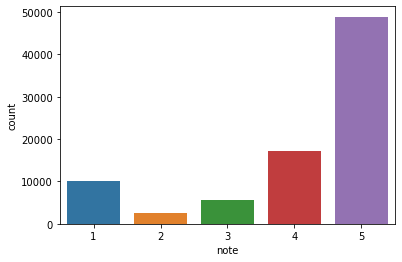

In [150]:
sns.countplot(df['note'])

In [78]:
df.isna().sum()

note            0
commentaire    54
dtype: int64

In [79]:
df = df[df['commentaire'].isna()==False]

In [80]:
# séparation de la variable cible et des variables explicatives
X = df['commentaire']
y = df['note'].values

In [81]:
# séparation du jeu de données en un dataset d'entrainement et un dataset de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(df_test.shape)

(67552,)
(16888,)
(100, 3)


In [83]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [84]:
# tokenisation des commentaires
num_words=5000
tk = Tokenizer(num_words=num_words, lower=True)

In [85]:
# entrainement de la tokenisation sur le X_train
tk.fit_on_texts(X_train)

In [86]:
# nb de ligne de la matrice
word_index = tk.word_index
len(tk.word_index)

35632

In [87]:
# nb de colonnes dans la matrice
vocabulary_size = tk.num_words
vocabulary_size

5000

In [88]:
# mise sous vecteur des commentaires
X_seq_train = tk.texts_to_sequences(X_train)
X_seq_test = tk.texts_to_sequences(X_test)

In [89]:
# affichage de la vectorisation réalisée
for x in range(0,5):
    print(X_seq_train[x])

[10, 125, 4, 831, 217]
[37, 12, 29, 325]
[102]
[7, 36]
[56, 28, 69, 4, 3, 101, 50, 991, 240]


Text(0.5, 1.0, 'commentaires bruts')

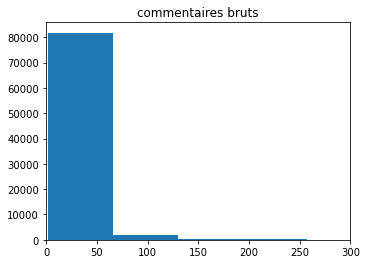

In [90]:
# affichage du nb de mots par commentaire pour nous aider à déterminer le nb de mots à choisir dans la matrice 
df['split'] = df['commentaire'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(df['split'])
plt.xlim([0, 300])
plt.title('commentaires bruts')

In [91]:
# transformation en matrice de même longueur par maxlen défini ci-dessous. Avec des 0 si colonne inférieure à maxlen
max_words = 130
X_pad_train = pad_sequences(X_seq_train, maxlen=max_words, padding='post')
X_pad_test= pad_sequences(X_seq_test, maxlen=max_words, padding='post')

In [92]:
# affice de la matrice
print(X_pad_train.shape)
X_pad_train

(67552, 130)


array([[  10,  125,    4, ...,    0,    0,    0],
       [  37,   12,   29, ...,    0,    0,    0],
       [ 102,    0,    0, ...,    0,    0,    0],
       ...,
       [   2,  123,   72, ...,    0,    0,    0],
       [   2,   36,  398, ...,    0,    0,    0],
       [  97,    7, 2706, ...,    0,    0,    0]])

In [93]:
# Création des couches du modéle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, Embedding, Dropout

embedding_size = 100

model_embedding_1 = Sequential()
model_embedding_1.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_words, embeddings_initializer='uniform'))  # On reprend le nb de mot choisi dans la tokenisation
model_embedding_1.add(GlobalAveragePooling1D())
model_embedding_1.add(Dense(units=256, activation='relu'))
model_embedding_1.add(Dropout(rate=0.3))
model_embedding_1.add(Dense(units=6, activation='softmax')) # En sortie le nb de units devra correspondre aux nb de variables cibles

model_embedding_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 130, 100)          500000    
                                                                 
 global_average_pooling1d_2   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 527,398
Trainable params: 527,398
Non-trainable params: 0
________________________________________________

In [94]:
# timer pour mesurer le temps écoulé entre les epochs de début et de fin de callback
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# instanciation la fonction TimingCallback()
time_callback = TimingCallback()

In [95]:
# Création des callback
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                          min_delta=0.01,
                          patience=3,
                          mode='min',
                          restore_best_weights=True,
                          verbose=1)

In [96]:
model_embedding_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
batch_size = 32
epochs = 10
history = model_embedding_1.fit(X_pad_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
                               callbacks=[early_stop, time_callback])

Epoch 1/10
1900/1900 [==============================] - 15s 7ms/step - loss: 0.8691 - accuracy: 0.6678 - val_loss: 0.8008 - val_accuracy: 0.6825
Epoch 2/10
1900/1900 [==============================] - 15s 8ms/step - loss: 0.7518 - accuracy: 0.6996 - val_loss: 0.7717 - val_accuracy: 0.7001
Epoch 3/10
1900/1900 [==============================] - 15s 8ms/step - loss: 0.7027 - accuracy: 0.7191 - val_loss: 0.7382 - val_accuracy: 0.7094
Epoch 4/10
1900/1900 [==============================] - 14s 8ms/step - loss: 0.6841 - accuracy: 0.7252 - val_loss: 0.7335 - val_accuracy: 0.7080
Epoch 5/10
1900/1900 [==============================] - 15s 8ms/step - loss: 0.6698 - accuracy: 0.7304 - val_loss: 0.7492 - val_accuracy: 0.7056
Epoch 6/10
1900/1900 [==============================] - 15s 8ms/step - loss: 0.6549 - accuracy: 0.7354 - val_loss: 0.7435 - val_accuracy: 0.7084
Epoch 6: early stopping


In [98]:
model_embedding_1.evaluate(X_pad_test, y_test, verbose=1)

528/528 [==============================] - 1s 2ms/step - loss: 0.7508 - accuracy: 0.7007


[0.7507736086845398, 0.7006750106811523]

### Calcul des prédictions sur le le de test cdiscount

In [99]:
# création des prédictions du eu de test cdiscount à partir du modèle
predict_cdiscount = model_embedding_1.predict(X_pad_test, verbose=1)

528/528 [==============================] - 1s 2ms/step


In [100]:
predict_cdiscount_class = predict_cdiscount.argmax(axis=1)
predict_cdiscount_class

array([4, 3, 5, ..., 5, 1, 3], dtype=int64)

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


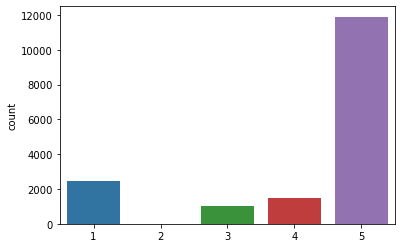

In [101]:
sns.countplot(predict_cdiscount_class)
plt.show();

### Calcul des prédictions sur le jeu de test amazon

In [102]:
df_test.head(2)

,Unnamed: 0,note,commentaire
0,0,1,MENZZONous aimerions savoir pourquoi vous ne retournez pas l'argent de vos clients et vous continuez à trouver des excuses à ce sujet. Les personnes qui donnent leur avis sur les réseaux sociaux vous bloqueront et leurs mails ne recevront pas de réponse. Pensez-vous que c'est normal?
1,1,1,"Voulant acheter un pare soleil de marque pour mon appareil photo le prix étant de 28 € environ quel a pas était ma surprise de voir ce prix grimper à 45 € en l'espace de 5 mn et tous ça sur le site Amazon y a t'il d'autres personnes à qui cela est arrivé , je serai curieux de lire vos témoignages ( pratiques de voyous)"


In [103]:
df_test.isna().sum()

Unnamed: 0     0
note           0
commentaire    0
dtype: int64

In [104]:
df_test = df_test.drop(columns=['Unnamed: 0'], axis=1)

In [105]:
# séparation de la variable cible et des variables explicatives
check_set = df_test['commentaire'].values

In [106]:
# vectorisation des token
check_seq = tk.texts_to_sequences(check_set)

In [107]:
# mise sous matrice numpy
check_pad = pad_sequences(check_seq, maxlen=max_words, padding='post')

In [108]:
check_pad

array([[ 305,  203,  609, ...,    0,    0,    0],
       [2033,  168, 4861, ...,    0,    0,    0],
       [ 322,  108,   27, ...,    0,    0,    0],
       ...,
       [   4,    3,   19, ...,    0,    0,    0],
       [   5,  776, 3924, ...,    0,    0,    0],
       [   4,  175,  124, ...,    0,    0,    0]])

In [109]:
# création des prédictions du jeu de test amazon à partir du modèle
check_predict = model_embedding_1.predict(check_pad, verbose=1)

4/4 [==============================] - 0s 3ms/step


In [110]:
print(check_predict)

[[2.41901053e-05 6.09354913e-01 1.49169430e-01 1.61593273e-01
  5.14513329e-02 2.84068752e-02]
 [2.83649279e-05 7.66385078e-01 9.82009917e-02 8.51290450e-02
  2.43332721e-02 2.59232391e-02]
 [5.49608812e-05 6.09104633e-01 1.40277132e-01 1.52798653e-01
  5.56978993e-02 4.20666747e-02]
 [3.02821536e-06 6.44652128e-01 1.52665854e-01 1.54378861e-01
  3.65540422e-02 1.17460629e-02]
 [2.57089678e-13 9.66082573e-01 2.71264631e-02 6.66895788e-03
  1.07081411e-04 1.49980015e-05]
 [4.11179320e-11 9.57200468e-01 3.14322561e-02 1.09263500e-02
  3.56353150e-04 8.46137336e-05]
 [3.73043374e-10 9.25361693e-01 5.07798456e-02 2.25809012e-02
  1.05958036e-03 2.17927838e-04]
 [9.16149795e-12 4.75499809e-01 2.52984107e-01 2.49662414e-01
  2.13386286e-02 5.15068590e-04]
 [1.01584055e-05 5.51119447e-01 1.68116838e-01 1.96614549e-01
  6.12805635e-02 2.28584111e-02]
 [6.66792186e-12 9.83286262e-01 1.30354110e-02 3.54329892e-03
  9.23781408e-05 4.25565013e-05]
 [2.39698622e-10 5.72839022e-01 2.25598946e-01 1.8

In [111]:
check_predict_class = check_predict.argmax(axis=1)
check_predict_class

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1,
       3, 3, 3, 1, 4, 1, 3, 4, 4, 4, 5, 1, 3, 5, 3, 1, 1, 5, 4, 5, 1, 4,
       3, 5, 1, 5, 4, 5, 5, 4, 1, 1, 1, 5, 4, 5, 5, 4, 1, 5, 5, 5, 1, 5,
       1, 4, 5, 5, 5, 5, 5, 1, 5, 5, 4, 5], dtype=int64)

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


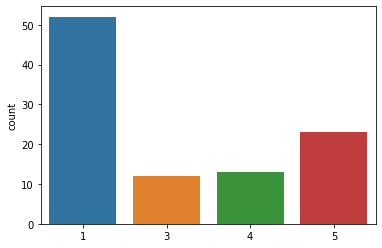

In [112]:
sns.countplot(check_predict_class);

In [113]:
# comparaison des prédictions et des notes du jeu de test
check_df = pd.DataFrame(list(zip(df_test.commentaire, df_test.note, check_predict_class)), columns=['commentaire', 'note', 'prediction'])
check_df.head()

,commentaire,note,prediction
0,MENZZONous aimerions savoir pourquoi vous ne retournez pas l'argent de vos clients et vous continuez à trouver des excuses à ce sujet. Les personnes qui donnent leur avis sur les réseaux sociaux vous bloqueront et leurs mails ne recevront pas de réponse. Pensez-vous que c'est normal?,1,1
1,"Voulant acheter un pare soleil de marque pour mon appareil photo le prix étant de 28 € environ quel a pas était ma surprise de voir ce prix grimper à 45 € en l'espace de 5 mn et tous ça sur le site Amazon y a t'il d'autres personnes à qui cela est arrivé , je serai curieux de lire vos témoignages ( pratiques de voyous)",1,1
2,Comment souvent problème d'envoi ou réception de marchandise biensure service client au téléphone ce n est pas leur faute c est les gens de l emballage belle esprit d équipe je ne commanderai plus chez vous,1,1
3,"L’arnaque des livreurs qui ne respectent pas les instructions des livraison, laissent le clos n’importe où le marquent livres alors qu ils ont pas livres! Le service client à part dire ; on va faire remonter l’info et ouvrir une enquête », ne fait rien! Avec l’argent qu engrange Amazon il s’agirait de s entourer de livreurs fiables !!",1,1
4,"J’ai commandé un article très cher qui est supposé être neuf. A ma surprise en recevant le colis l l’article semble déjà ouvert/voir même déjà utilisé, le carton de l’article était déchiré.. étant la grosse somme que j’ai dépensé sur cet article je ne peux accepter de recevoir du reconditionné au prix du neuf. En demandant le retour Amazon refuse de me rembourser sur carte bancaire mais plutôt uniquement par avoir et ça c’est absurde car c’est pas de ma faute c’est la faute à Amazon, d’ailleurs pourquoi m’obliger à consommer par force une telle grosse somme sur leur site, moi je veux pas d’avoir je veux mon argent sur mon compte bancaire !!!! J’ai commencé les démarches pour ouvrir un contentieux contre Amazon !",1,1


In [114]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, predict_cdiscount_class)
print(cr)

cm = pd.crosstab(y_test, predict_cdiscount_class, rownames=['données réelles'], colnames=['predictions'])
display(cm)

# vérification des résultats sur un jeu de test externe (100 commentaires amazon également répartis entre les étoiles)

cm_test = classification_report(df_test.note, check_predict_class)
print(cm_test)

cm_test2 = pd.crosstab(df_test.note, check_predict_class, rownames=['données réelles'], colnames=['predictions'])
display(cm_test2)

cm_test3 = pd.crosstab(df_test.note, check_predict_class, rownames=['données réelles'], colnames=['predictions'], normalize=0)
display(cm_test3)

for i in cm_test3.index:
    for j in cm_test3.columns :
        if (i==j and cm_test3.loc[i, j] > 0.5) :
            print("les prédictions correctes sont supérieures à 50% pour {} étoile(s) avec {:0.0%}".format(i, cm_test3.loc[i, j]))

              precision    recall  f1-score   support

           1       0.69      0.85      0.76      1985
           2       0.18      0.00      0.01       537
           3       0.35      0.29      0.32      1217
           4       0.46      0.20      0.28      3429
           5       0.76      0.94      0.84      9720

    accuracy                           0.70     16888
   macro avg       0.49      0.46      0.44     16888
weighted avg       0.64      0.70      0.65     16888



predictions,1,2,3,4,5
données réelles,,,,,
1,1693,8,134,52,98
2,248,2,155,60,72
3,307,1,359,289,261
4,121,0,258,682,2368
5,96,0,122,405,9097


              precision    recall  f1-score   support

           1       0.35      0.90      0.50        20
           2       0.00      0.00      0.00        20
           3       0.67      0.40      0.50        20
           4       0.38      0.25      0.30        20
           5       0.57      0.65      0.60        20

    accuracy                           0.44       100
   macro avg       0.39      0.44      0.38       100
weighted avg       0.39      0.44      0.38       100



C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t.fourtouill\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predictions,1,3,4,5
données réelles,,,,
1,18,1,1,0
2,18,2,0,0
3,6,8,4,2
4,6,1,5,8
5,4,0,3,13


predictions,1,3,4,5
données réelles,,,,
1,0.9,0.05,0.05,0.00
2,0.9,0.10,0.00,0.00
3,0.3,0.40,0.20,0.10
4,0.3,0.05,0.25,0.40
5,0.2,0.00,0.15,0.65


les prédictions correctes sont supérieures à 50% pour 1 étoile(s) avec 90%
les prédictions correctes sont supérieures à 50% pour 5 étoile(s) avec 65%


In [115]:
import os
path = "/Users/t.fourtouill/Downloads/SatisfactionClients"
os.makedirs(path, exist_ok=True)
model_embedding_1.save('datasets/SatisfactionClients/model_embedding6')

INFO:tensorflow:Assets written to: datasets/SatisfactionClients/model_embedding6\assets


### Evaluation sur 2 sentiments : négatif et positif

* Le DataSet cdiscount a été retraité en renommant, les notes 1 et 2 en 0, les notes 4 et 5 en 1 et en supprimant les notes 3
* Le but étant d'isoler de manière moins complexe les sentiments négatifs et les sentiments positifs et ainsi améliorer la qualité du résultat prédit

In [116]:
df_0_1 = pd.read_csv('datasets/SatisfactionClients/cdiscount_0_1.csv')
df_test_0_1 = pd.read_csv('datasets/SatisfactionClients/amazon_test1.csv')

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


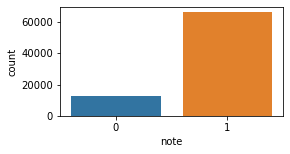

In [117]:
plt.figure(figsize=(4, 2))
sns.countplot(df_0_1['note'])
plt.show();

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


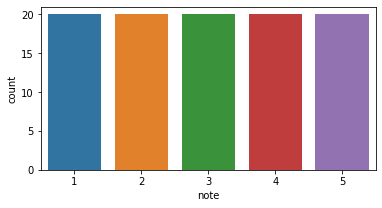

In [118]:
plt.figure(figsize=(6, 3))
sns.countplot(df_test_0_1['note'])
plt.show();

In [119]:
df_0_1.isna().sum()

note            0
commentaire    46
dtype: int64

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


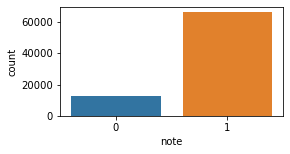

In [120]:
df_0_1 = df_0_1[df_0_1['commentaire'].isna()==False]
df_0_1 = df_0_1[df_0_1['note']!=3]
df_0_1['note'] = df_0_1['note'].replace({'1' : '0', '2' : '0', '4' : '1', '5' : '1'})

plt.figure(figsize=(4, 2))
sns.countplot(df_0_1['note'])
plt.show();

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


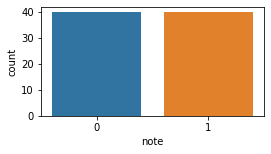

In [121]:
df_test_0_1 = df_test_0_1.drop(columns=['Unnamed: 0'])
df_test_0_1 = df_test_0_1[df_test_0_1['commentaire'].isna()==False]
df_test_0_1 = df_test_0_1[df_test_0_1['note']!=3]
df_test_0_1['note'] = df_test_0_1['note'].replace({1 : 0, 2 : 0, 4 : 1, 5 : 1})

plt.figure(figsize=(4, 2))
sns.countplot(df_test_0_1['note'])
plt.show();

In [122]:
# séparation de la variable cible et des variables explicatives
X1 = df_0_1['commentaire']
y1 = df_0_1['note']

In [123]:
# séparation du jeu de données en un dataset d'entrainement et un dataset de test
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, shuffle=True)

In [124]:
# entrainement de la tokenisation sur le X_train
tk.fit_on_texts(X_train1)

In [125]:
# nb de ligne de la matrice
word_index = tk.word_index
len(tk.word_index)

39023

In [126]:
# nb de colonnes dans la matrice
vocabulary_size = tk.num_words
vocabulary_size

5000

In [127]:
# mise sous vecteur des commentaires
X_seq_train1 = tk.texts_to_sequences(X_train1)
X_seq_test1 = tk.texts_to_sequences(X_test1)

In [128]:
# affichage de la vectorisation réalisée
for x in range(0,5):
    print(X_seq_train1[x])

[16, 2, 129, 1057, 33, 252, 3, 1418, 100]
[16, 6]
[190, 96, 233]
[12, 649, 128]
[8, 608, 1107, 58, 41, 394, 103, 84, 23, 41, 9, 1811, 178, 23, 2695, 1, 81, 9, 178, 126, 142, 3660, 17]


In [129]:
# transformation en matrice de même longueur par maxlen défini ci-dessous. Avec des 0 si colonne inférieure à maxlen
max_words = 130
X_pad_train1 = pad_sequences(X_seq_train1, maxlen=max_words, padding='post')
X_pad_test1 = pad_sequences(X_seq_test1, maxlen=max_words, padding='post')

In [130]:
# affice de la matrice
print(X_pad_train1.shape)
X_pad_train1

(63065, 130)


array([[  16,    2,  129, ...,    0,    0,    0],
       [  16,    6,    0, ...,    0,    0,    0],
       [ 190,   96,  233, ...,    0,    0,    0],
       ...,
       [  40,   25,   11, ...,    0,    0,    0],
       [   7, 3152,    5, ...,    0,    0,    0],
       [ 159,   26,   21, ...,    0,    0,    0]])

In [131]:
# Création des couches du modéle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, Embedding, Dropout

embedding_size = 100

model_0_1_embedding_1 = Sequential()
model_0_1_embedding_1.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_words, embeddings_initializer='uniform'))  # On reprend le nb de mot choisi dans la tokenisation
model_0_1_embedding_1.add(GlobalAveragePooling1D())
model_0_1_embedding_1.add(Dense(units=256, activation='relu'))
model_0_1_embedding_1.add(Dropout(rate=0.3))
model_0_1_embedding_1.add(Dense(units=1, activation='sigmoid')) # En sortie le nb de units devra correspondre aux nb de variables cibles

model_0_1_embedding_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 100)          500000    
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               25856     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 526,113
Trainable params: 526,113
Non-trainable params: 0
________________________________________________

In [132]:
model_0_1_embedding_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [133]:
batch_size = 32
epochs = 10
history_0_1 = model_0_1_embedding_1.fit(X_pad_train1, y_train1, batch_size=batch_size, epochs=epochs, validation_split=0.1,
                               callbacks=[early_stop, time_callback])

Epoch 1/10
1774/1774 [==============================] - 15s 8ms/step - loss: 0.1841 - accuracy: 0.9309 - val_loss: 0.1449 - val_accuracy: 0.9534
Epoch 2/10
1774/1774 [==============================] - 14s 8ms/step - loss: 0.1163 - accuracy: 0.9569 - val_loss: 0.1218 - val_accuracy: 0.9534
Epoch 3/10
1774/1774 [==============================] - 14s 8ms/step - loss: 0.1026 - accuracy: 0.9618 - val_loss: 0.1226 - val_accuracy: 0.9539
Epoch 4/10
1774/1774 [==============================] - 14s 8ms/step - loss: 0.0940 - accuracy: 0.9650 - val_loss: 0.1461 - val_accuracy: 0.9501
Epoch 5/10
1774/1774 [==============================] - 14s 8ms/step - loss: 0.0861 - accuracy: 0.9688 - val_loss: 0.1561 - val_accuracy: 0.9501
Epoch 5: early stopping


In [134]:
model_0_1_embedding_1.evaluate(X_pad_test1, y_test1, verbose=1)

493/493 [==============================] - 1s 2ms/step - loss: 0.1151 - accuracy: 0.9571


[0.11511775851249695, 0.9571256637573242]

### Calcul des prédictions négatives et positives sur le jeu de test cdiscount

In [135]:
# création des prédictions du eu de test cdiscount à partir du modèle
predict_cdiscount1 = model_0_1_embedding_1.predict(X_pad_test1, verbose=1)

493/493 [==============================] - 1s 2ms/step


In [136]:
predict_cdiscount1

array([[0.2523619 ],
       [0.97617435],
       [0.7759021 ],
       ...,
       [0.41580522],
       [0.999653  ],
       [0.99997914]], dtype=float32)

In [137]:
predict_cdiscount_class1 = predict_cdiscount1.round().astype('int').ravel()
predict_cdiscount_class1

array([0, 1, 1, ..., 0, 1, 1])

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


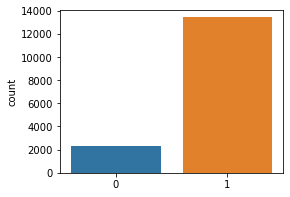

In [138]:
plt.figure(figsize=(4, 3))
sns.countplot(predict_cdiscount_class1)
plt.show();

### Calcul des prédictions négatives et positives sur le jeu de test amazon

In [139]:
# séparation de la variable cible et des variables explicatives
check_set_amazon = df_test_0_1['commentaire'].values

In [140]:
# vectorisation des token
check_seq_amazon = tk.texts_to_sequences(check_set_amazon)

In [141]:
# mise sous matrice numpy
check_pad_amazon = pad_sequences(check_seq_amazon, maxlen=max_words, padding='post')

In [142]:
# création des prédictions du jeu de test amazon à partir du modèle
check_predict_0_1 = model_0_1_embedding_1.predict(check_pad_amazon, verbose=1)

3/3 [==============================] - 0s 2ms/step


In [143]:
for i in range(10):
    print(check_predict_0_1[i])

[0.11085403]
[0.15433058]
[0.15890971]
[0.10360307]
[0.0029231]
[0.00900808]
[0.01428121]
[0.02093473]
[0.12012017]
[0.0024094]


In [144]:
check_predict_0_1_class = check_predict_0_1.round().astype('int').ravel()
check_predict_0_1_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

C:\Users\t.fourtouill\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


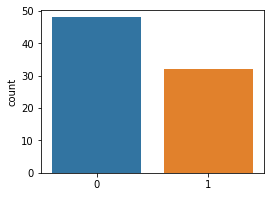

In [145]:
plt.figure(figsize=(4, 3))
sns.countplot(check_predict_0_1_class)
plt.show();

In [146]:
# comparaison des prédictions et des notes du jeu de test
check_df_0_1 = pd.DataFrame(list(zip(df_test_0_1.commentaire, df_test_0_1.note, check_predict_0_1_class)), columns=['commentaire', 'note', 'prediction'])
check_df.head()

,commentaire,note,prediction
0,MENZZONous aimerions savoir pourquoi vous ne retournez pas l'argent de vos clients et vous continuez à trouver des excuses à ce sujet. Les personnes qui donnent leur avis sur les réseaux sociaux vous bloqueront et leurs mails ne recevront pas de réponse. Pensez-vous que c'est normal?,1,1
1,"Voulant acheter un pare soleil de marque pour mon appareil photo le prix étant de 28 € environ quel a pas était ma surprise de voir ce prix grimper à 45 € en l'espace de 5 mn et tous ça sur le site Amazon y a t'il d'autres personnes à qui cela est arrivé , je serai curieux de lire vos témoignages ( pratiques de voyous)",1,1
2,Comment souvent problème d'envoi ou réception de marchandise biensure service client au téléphone ce n est pas leur faute c est les gens de l emballage belle esprit d équipe je ne commanderai plus chez vous,1,1
3,"L’arnaque des livreurs qui ne respectent pas les instructions des livraison, laissent le clos n’importe où le marquent livres alors qu ils ont pas livres! Le service client à part dire ; on va faire remonter l’info et ouvrir une enquête », ne fait rien! Avec l’argent qu engrange Amazon il s’agirait de s entourer de livreurs fiables !!",1,1
4,"J’ai commandé un article très cher qui est supposé être neuf. A ma surprise en recevant le colis l l’article semble déjà ouvert/voir même déjà utilisé, le carton de l’article était déchiré.. étant la grosse somme que j’ai dépensé sur cet article je ne peux accepter de recevoir du reconditionné au prix du neuf. En demandant le retour Amazon refuse de me rembourser sur carte bancaire mais plutôt uniquement par avoir et ça c’est absurde car c’est pas de ma faute c’est la faute à Amazon, d’ailleurs pourquoi m’obliger à consommer par force une telle grosse somme sur leur site, moi je veux pas d’avoir je veux mon argent sur mon compte bancaire !!!! J’ai commencé les démarches pour ouvrir un contentieux contre Amazon !",1,1


In [147]:
from sklearn.metrics import classification_report

# vérification des résultats sur un jeu de test externe (100 commentaires amazon également répartis entre les étoiles)

cm_test1_0_1 = classification_report(df_test_0_1.note, check_predict_0_1_class)
print(cm_test1_0_1)

cm_test2_0_1 = pd.crosstab(df_test_0_1.note, check_predict_0_1_class, rownames=['données réelles'], colnames=['predictions'])
display(cm_test2_0_1)

cm_test3_0_1 = pd.crosstab(df_test_0_1.note, check_predict_0_1_class, rownames=['données réelles'], colnames=['predictions'], normalize=0)
display(cm_test3_0_1)

for i in cm_test3_0_1.index:
    for j in cm_test3_0_1.columns :
        if (i==j and cm_test3_0_1.loc[i, j] > 0.5) :
            print("les prédictions correctes sont supérieures à 50% pour {} étoile(s) avec {:0.0%}".format(i, cm_test3_0_1.loc[i, j]))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89        40
           1       0.97      0.78      0.86        40

    accuracy                           0.88        80
   macro avg       0.89      0.88      0.87        80
weighted avg       0.89      0.88      0.87        80



predictions,0,1
données réelles,,
0,39,1
1,9,31


predictions,0,1
données réelles,,
0,0.975,0.025
1,0.225,0.775


les prédictions correctes sont supérieures à 50% pour 0 étoile(s) avec 98%
les prédictions correctes sont supérieures à 50% pour 1 étoile(s) avec 78%


In [148]:
import os
path = "/Users/t.fourtouill/Downloads/SatisfactionClients"
os.makedirs(path, exist_ok=True)
model_0_1_embedding_1.save('datasets/SatisfactionClients/model_0_1_embedding6')

INFO:tensorflow:Assets written to: datasets/SatisfactionClients/model_0_1_embedding6\assets
